# Cycle Life Prediction: Generalized Severson Analysis

This notebook generalizes the analysis presented in Severson's 2019 Nature Energy paper for cycle life prediction from the first 100 cycles of test data.

Through a series of widgets, users can select any number of Train and Test datasets from the Voltaiq Community server, featurize those datasets based on generalizations of the features in Severson et al, train and test the Severson Variance and/or Discharge models on the Train/Test datasets, evaluate model performance, and predict cycle life for any number of Prediction datasets of interest.

### Inputs:
- **Model(s):** Users can select which models they would like to evaluate. We currently offer comparisons between the Severson Variance, Severson Discharge and Dummy models, but will continue to add in additional models from the literature. We also plan to allow users to specify their own models in the future.
    - Once a model is selected, users can Train and Test their models, including showing parity plots, RMSE and MAPE performance plots for their selected model(s).
- **Featurization inputs:** The train and test data will be featurized based on the Severson models, with the following nuances:
    - Rather than using a hard-coded reference capacity for 80% capacity retention, we allow for a flexible capacity retention threshold based on the initial capacity of a test. Instead of choosing the first cycle to drop below the capacity retention threshold, we choose the first cycle to do so within a sequence of 5 consecutive cycles; this provides some robustness against noise/fluctuations
    - A user also inputs the `start` and `end` cycles for which to perform the differencing for the voltage vs capacity data. The default is cycles 9 and 99 to correspond with the Severson analysis (note that Voltaiq uses zero-indexing on cycles as a default, unless they are explicitly specified in an input file). Note that all tests within the Train and Test datasets must include these two cycles.
    - A cycle number must also be given from which to calculate reference capacity. The current script implementation allows a user to choose a cycle ordinal from which to calculate a reference capacity. The Severson model used cell nominal capacity as a reference capacity; however this is not known for each dataset on Voltaiq Community. Thus, a reference capacity based on the cycling data is chosen instead. Currently this cycle number must be the same for all datasets used for the model. A fixed reference cycle choice requires a user to have some information about what cycle to choose – the default ordinal is cycle 20 as that works for the curated datasets provided with this script.
    - Voltage vs capacity data is still interpolated between the min and max values for each test record; note that the features based on a specific voltage cutoff are no longer applicable
- **Train dataset:** Data which will be used to train the ML model(s) you choose. Choose from a number of curated publicly-available datasets, and/or choose custom data based on a test name search criteria
    - Tests must include the same `start` and `end` cycle for the analysis range and tests should also obtain the expected end capacity retention %. If tests do not contain the `start` and `end`cycles, the code will throw an error. If tests do not meet the expected capacity retention %, those tests will be excluded from the Train and Test featurization and model evaluation.
    - We provide an option for filtering data based on a minimum cycle count, as well as the set capacity retention threshold. Filtering by capacity retention threshold can be slow, so should be used in conjunction with a cycle number and/or test name filter.
- **Test dataset:** Data which will be used to test (evaluate the performance) of the ML model(s) you choose. You may either choose to perform a train-test split (with a configurable split ratio) on the Train dataset, or manually choose data in a manner similar to how you chose the Train dataset.
- **Prediction dataset:** After a model is trained and evaluated on the test dataset, users can select a Prediction dataset, and use the ML model(s) of their choice to predict the cycle life of this new dataset. Again, users can select from a curated list or choose a custom dataset based on a test name search criteria.
    

### Outputs:
- Train/Test parity plots, RMSE, MAPE performance plots
- The prediction step will generate a bar chart comparing the predicted cycle life for each model for each test record within the dataset, as well as the current (last) cycle of that test record
- All train/test results can be accessed through methods and attributes of the CL_prediction class. Further exploration of the data results is possible using the resulting dataframes.

### Recommended datasets:
The Severson models were developed on fast-charge LFP cycling data. The Variance model contains a single feature based on the variance of the difference between voltage vs capacity curves of two cycles (`start` and `end`). It is likely that these ML models are degradation mode specific. Since the expected degradation mode of the original dataset focused on loss of active material of the negative electrode, cells which have that degradation mode might show better fits. Additionally, it is recommended that similar discharge protocols and cut-off voltages are used for comparison/calculate purposes for the datasets. This is because the features are calculated based on discharge steps, and data is interpolated between the upper and lower cutoff voltages. Significantly different cycling protocols might not allow the ML model to capture the appropriate feature signatures.

#### Reference: 
Severson et al. Data-driven prediction of battery cycle life before capacity degradation. Nature Energy volume 4, pages 383–391 (2019)


#### Imports and set-up

In [1]:
import voltaiq_studio as vs
from voltaiq_studio import TraceFilterOperation

import severson_featurization
import CL_prediction, ML_models
import cl_widgets as cpw
import importlib
importlib.reload(CL_prediction)
importlib.reload(ML_models)
importlib.reload(severson_featurization)
importlib.reload(cpw)
from CL_prediction import CLPrediction
from severson_featurization import calc_X_and_y, drop_unfinished_tests

import ipywidgets as widgets
from ipywidgets import interactive, interact, fixed

from IPython.display import display, Markdown

import numpy as np
import pandas as pd
from scipy import stats
import math

import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
import seaborn as sns

# set a few default figure parameters
mpl.rcParams['figure.figsize'] = (3,3)
colors = ['#DBDF00', '#68CCCA','#AEA1FF','#73D8FF','#FDA1FF','#9F0500','#C45100','#FB9E00',]
mpl.rcParams['axes.prop_cycle'] = cycler(color=colors)
fontsize = 6
titlesize = 8
mpl.rcParams['font.size'] = fontsize
mpl.rcParams['legend.fontsize'] = fontsize
mpl.rcParams['figure.titlesize'] = titlesize
mpl.rcParams['axes.labelsize']=fontsize
mpl.rcParams['lines.markersize'] = fontsize
mpl.rcParams['figure.dpi'] = 150

In [2]:
trs = vs.get_test_records()

### User inputs: Select Model(s), Model Inputs, Train data and Test data

In [3]:
# we will start by instantiating a cycle life prediction object 
# which will store all relevant information for the datasets and models you will choose
prediction1 = CL_prediction.CLPrediction()

#### Select Models

In [4]:
model_options = ['All','Dummy','Severson variance','Severson discharge']
def set_model(model_choice):
    set_models = list(model_choice)
    if 'All' in model_choice:
        set_models = list(model_options)
        set_models.remove('All')
    prediction1.set_model(set_models)

In [5]:
choose_model = interactive(set_model, model_choice = widgets.SelectMultiple(options = model_options, value=['All'], description='Choose ML model(s)',style={'description_width': 'initial'},disabled=False))
display(choose_model)

interactive(children=(SelectMultiple(description='Choose ML model(s)', index=(0,), options=('All', 'Dummy', 'S…

#### Select Featurization Criteria

In [6]:
featurize = interactive(cpw.featurize_inputs_widget, start_cycle = widgets.IntText(value = 20, description = 'Initial cycle: ', disabled=False,continuous_update = False),
                        end_cycle = widgets.IntText(value = 99, description = 'End cycle: ', disabled=False,continuous_update = False),
                        per_cap_ret = widgets.BoundedFloatText(value = 0.85,min = 0, max = 1, step = 0.01, description = '% Capacity Retention:',style={'description_width': 'initial'}, disabled=False,continuous_update = False),
                       prediction1 = fixed(prediction1),ref_cyc = widgets.BoundedFloatText(value = 20, min = 0, step = 1, description = "Reference cycle for capacity normalization",style={'description_width': 'initial'} ))
display(featurize)

interactive(children=(IntText(value=20, description='Initial cycle: '), IntText(value=99, description='End cyc…

#### Select Training Dataset

In [7]:
display(Markdown("#### Search for test records to add to Train dataset"))
display(Markdown("Filtering tests by capacity retention is slow; check kernel status for update on completion."))
# search_type = widgets.RadioButtons(options=['Test Name','Min Cycle Number','Both'],
#                                     disabled=False)
# Want to add in some search criteria here: min cycle number (if blank, ignore), min capacity retention

select_train = interactive(cpw.select_widget, 
                           train_sets = widgets.SelectMultiple(value=[], options=cpw.std_train_datasets, description=f'Training Datasets:',style={'description_width': 'initial'}, ensure_option=True),
                          train_or_test=fixed('train'), pred_obj = fixed(prediction1), trs = fixed(trs), predict_button = fixed(None))

display(select_train)

#### Search for test records to add to Train dataset

Filtering tests by capacity retention is slow; check kernel status for update on completion.

interactive(children=(SelectMultiple(description='Training Datasets:', options=('Severson2019 - All (LFP)', 'S…

#### Select Testing Dataset (or train-test-split ratio)

In [8]:
test_select_dropdown = interactive(cpw.test_select_method,method = widgets.Dropdown(options = ['Use train_test_split on training dataset','Select test dataset manually'], 
                                                                                value = None, description = 'Test dataset selection method', style={'description_width': 'initial'},
                                                                                layout = widgets.Layout(width='500px')), prediction1 = fixed(prediction1), trs = fixed(trs),predict_button=fixed(None))
display(test_select_dropdown)

interactive(children=(Dropdown(description='Test dataset selection method', layout=Layout(width='500px'), opti…

#### Featurize the data

In [9]:
output = widgets.Output()
perform_featurize = widgets.Button(description = 'Featurize data', button_style = 'danger', style={"button_color": "#38adad"})

display(perform_featurize, output)

def featurize(b):
    ''' function that will featurize the data'''
    with output:
        cpw.populate_test_train_data(prediction1, trs)
        print("Starting featurization...")
        prediction1.featurize(trs)
        print("Featurization complete!")

perform_featurize.on_click(featurize)

Button(button_style='danger', description='Featurize data', style=ButtonStyle(button_color='#38adad'))

Output()

#### Train & Test ML model(s)

In [10]:
train_model_button = widgets.Button(description = 'Train model', button_style = 'danger', style={"button_color": "#38adad"})
test_button = widgets.Button(description = 'Test model', button_style = 'danger', style={"button_color": "#38adad"},disabled=True,)
parity_button = widgets.Button(description = 'Generate Parity Plots', button_style = 'danger', style={"button_color": "#38adad"},disabled=True)
MAPE_button = widgets.Button(description = 'Plot MAPE results', button_style = 'danger', style={"button_color": "#38adad"},disabled=True)
RMSE_button = widgets.Button(description = 'Plot RMSE results', button_style = 'danger', style={"button_color": "#38adad"},disabled=True)


output = widgets.Output()
display(train_model_button, test_button,parity_button,MAPE_button,RMSE_button, output)

def train_button(b):
    with output:
        prediction1.train_model()
        test_button.disabled = False

def test_click(b):
    with output:
        prediction1.test_predict()
        parity_button.disabled = False
        MAPE_button.disabled = False
        RMSE_button.disabled = False
        
def parity_click(b):
    with output:
        prediction1.create_parity_plots()

def mape_click(b):
    with output:
        prediction1.plot_model_stats('MAPE')
        prediction1.plot_grouped_model_stats('MAPE')
        
def rmse_click(b):
    with output:
        prediction1.plot_model_stats('RMSE')
        
train_model_button.on_click(train_button)
test_button.on_click(test_click)
parity_button.on_click(parity_click)
MAPE_button.on_click(mape_click)
RMSE_button.on_click(rmse_click)

Button(button_style='danger', description='Train model', style=ButtonStyle(button_color='#38adad'))

Button(button_style='danger', description='Test model', disabled=True, style=ButtonStyle(button_color='#38adad…

Button(button_style='danger', description='Generate Parity Plots', disabled=True, style=ButtonStyle(button_col…

Button(button_style='danger', description='Plot MAPE results', disabled=True, style=ButtonStyle(button_color='…

Button(button_style='danger', description='Plot RMSE results', disabled=True, style=ButtonStyle(button_color='…

Output()

#### Exploring data feature distributions

First, identify the most important features for the Severson Discharge model (skip this step if the model was not chosen.

Next, plot the feature distributions of the three most important features in terms of model weighting.

In [11]:
eNet_dchg_coef = pd.DataFrame()
eNet_dchg_coef['features'] = prediction1.trained_models['Severson discharge'].pipeline.named_steps['enet'].coef_
eNet_dchg_coef['coef'] = prediction1.trained_models['Severson discharge'].X_train.columns
eNet_dchg_coef['abs_features'] = abs(eNet_dchg_coef['features'])
eNet_dchg_coef_sorted = eNet_dchg_coef.sort_values('abs_features',ascending=False)
eNet_dchg_coef_sorted.reset_index(inplace=True,drop=True)
eNet_dchg_coef_sorted.drop(columns=['abs_features'],inplace=True)

eNet_dchg_coef_sorted

,features,coef
0,-0.087075,mean_deltaQ
1,-0.058671,var_deltaQ
2,0.017622,intcpt_22_99
3,-0.010282,slope_22_99
4,-0.006508,kur_deltaQ
5,-0.000000,min_deltaQ
6,0.000000,skew_deltaQ
7,0.000000,deltaQ_lowV
8,-0.000000,slope_90_99
9,0.000000,intcpt_90_99


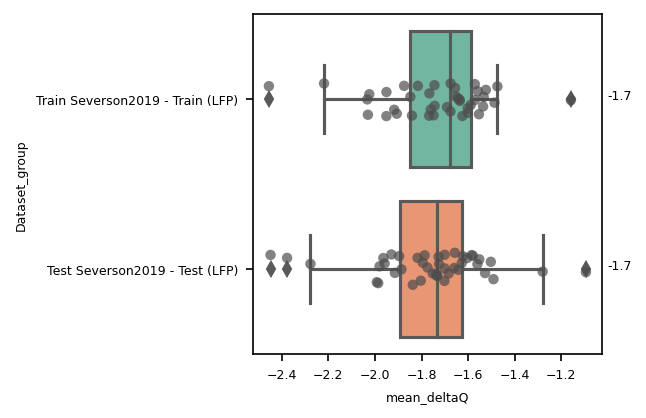

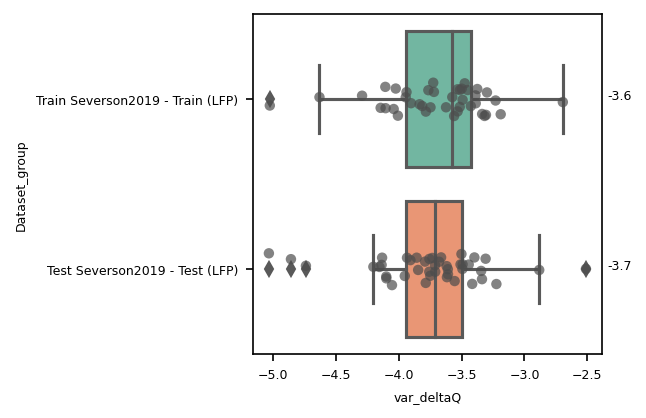

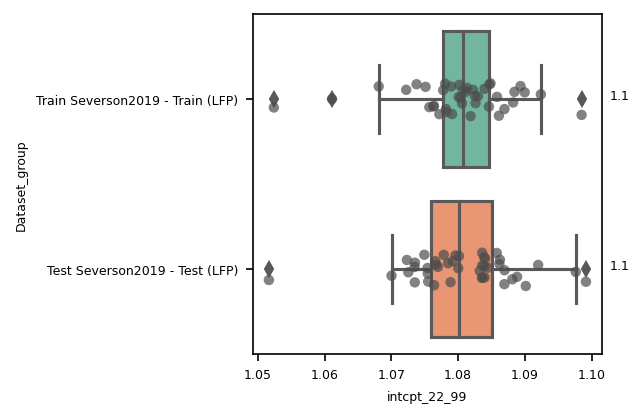

In [12]:
for feature in eNet_dchg_coef_sorted.coef[0:3]:
    prediction1.grouped_feature_distribution(feature)

#### Pearson correlation coefficient plots and analysis

In [13]:
train_test_variance_grp = pd.concat([prediction1.X_train[['Dataset_group','var_deltaQ']],prediction1.X_test[['Dataset_group','var_deltaQ']]],ignore_index=True)
train_test_log_cyc = pd.concat([prediction1.y_train[['log_cyc_life']],prediction1.y_test[['log_cyc_life']]],ignore_index=True)

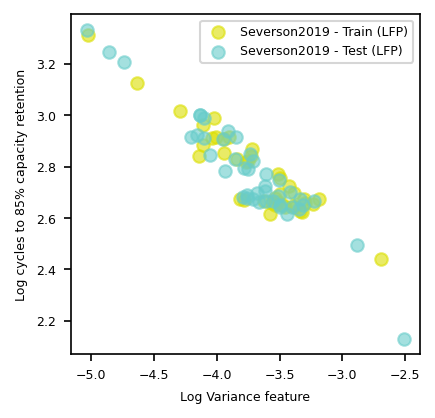

In [14]:
unique_grps = pd.unique(train_test_variance_grp.Dataset_group)

for grp in unique_grps:
    train_idx = train_test_variance_grp[train_test_variance_grp.Dataset_group == grp].index
    plt.scatter(x=train_test_variance_grp.var_deltaQ[train_idx],y=train_test_log_cyc.log_cyc_life[train_idx],label=grp,alpha=0.6)
# plt.yscale('log')
plt.legend(loc='best',bbox_to_anchor=(1,1))
# plt.axis('square')
plt.ylabel('Log cycles to 85% capacity retention')
plt.xlabel('Log Variance feature')
plt.show()

In [15]:
pearson_correlation = pd.DataFrame()
names = []
correlation = []
for grp in unique_grps:
    train_idx = train_test_variance_grp[train_test_variance_grp.Dataset_group == grp].index
    var = train_test_variance_grp.var_deltaQ[train_idx]
    lftm = train_test_log_cyc.log_cyc_life[train_idx]
    names.append(grp)
    correlation.append(stats.pearsonr(var, lftm)[0])
pearson_correlation['Dataset']=names
pearson_correlation['Pearson Correlation Coefficient'] = correlation
pearson_correlation

,Dataset,Pearson Correlation Coefficient
0,Severson2019 - Train (LFP),-0.930378
1,Severson2019 - Test (LFP),-0.950874


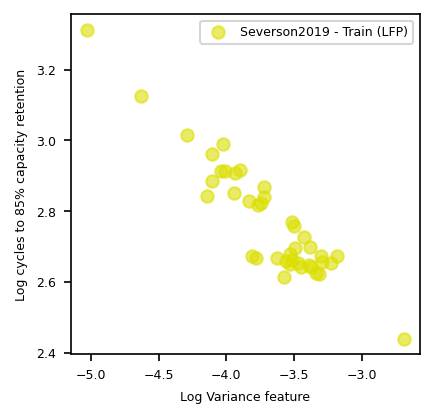

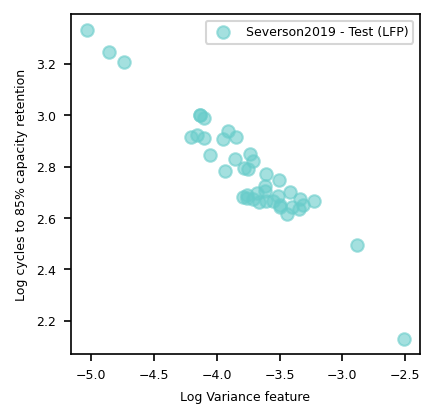

In [16]:
i=0
colors = colors*math.ceil(len(unique_grps)/len(colors))
for grp in unique_grps:
    train_idx = train_test_variance_grp[train_test_variance_grp.Dataset_group == grp].index
    plt.scatter(x=train_test_variance_grp.var_deltaQ[train_idx],y=train_test_log_cyc.log_cyc_life[train_idx],label=grp,alpha=0.6,c=colors[i])
    plt.legend()
    plt.ylabel('Log cycles to 85% capacity retention')
    plt.xlabel('Log Variance feature')
    plt.show()
    i+=1

#### Tabular data
The following code sections allow users to look at tabular data of the Test and Train dataset performance. Users will have to change the model and train_vs_test to update the dataframe that is returned

In [17]:
train_vs_test = "test"

prediction1.return_prediction_dataframes(train_vs_test)

,Name,Dummy Predicted cycle life,Severson variance Predicted cycle life,Severson discharge Predicted cycle life,Actual cycle life
0,2017-05-12_3_6C-80per_3_6C_CH1_VDF,591.681462,1588.813740,1507.547058,1759.0
1,2017-05-12_3_6C-80per_3_6C_CH3_VDF,591.681462,1842.853624,1798.889673,2150.0
2,2017-05-12_4C-80per_4C_CH6_VDF,591.681462,1436.544717,1364.130185,1612.0
3,2017-05-12_4_8C-80per_4_8C_CH10_VDF,591.681462,727.764791,742.168201,609.0
4,2017-05-12_5_4C-40per_3_6C_CH20_VDF,591.681462,863.158203,876.684053,1006.0
5,2017-05-12_5_4C-60per_3C_CH15_VDF,591.681462,875.847022,837.355192,839.0
6,2017-05-12_5_4C-60per_3_6C_CH23_VDF,591.681462,912.632674,893.756137,820.0
7,2017-05-12_5_4C-70per_3C_CH17_VDF,591.681462,602.652087,574.952546,661.0
8,2017-05-12_5_4C-80per_5_4C_CH11_VDF,591.681462,469.410828,471.096423,502.0
9,2017-05-12_6C-30per_3_6C_CH32_VDF,591.681462,836.445801,812.178830,971.0


#### Select Prediction dataset, and predict cycle lives

In [18]:
# next step is to allow users to select data for prediction. That needs to be featurized (but no y-values) and then the CL values can be predicted and shared (how to visualize...?)

predict_model_predict = widgets.Button(description = 'Predict Lifetime', button_style = 'danger', style={"button_color": "#38adad"}, disabled = True)

display(Markdown("#### Search for test records to add to Prediction dataset"))
display(Markdown("Filtering tests by capacity retention is slow; check kernel status for update on completion."))
# search_type = widgets.RadioButtons(options=['Test Name','Min Cycle Number','Both'],
#                                     disabled=False)
# Want to add in some search criteria here: min cycle number (if blank, ignore), min capacity retention

select_predict = interactive(cpw.select_widget, 
                           train_sets = widgets.SelectMultiple(value=[], options=cpw.std_train_datasets, description=f'Prediction Datasets:',style={'description_width': 'initial'}, ensure_option=True),
                          train_or_test=fixed('predict'), pred_obj = fixed(prediction1), trs = fixed(trs), predict_button = fixed(predict_model_predict))

# interactive(cpw.custom_select, filter_by_cap_retention = widgets.Checkbox(value=False,description='Filter tests by capacity retention threshold',
#                                                                                          style={'description_width': 'initial'}),
#                            min_cyc_num = widgets.IntText(description = 'Minimum # of cycles:',style={'description_width': 'initial'}, value = prediction1.get_end_cycle()+1),
#                            other_search_text = widgets.Text(
#                 value = prediction1.get_last_custom_search(),description='Test name search:', 
#                 style={'description_width': 'initial'},continuous_update=False),
#                                      train_or_test=fixed('predict'), prediction1 = fixed(prediction1),
#                                      trs = fixed(trs),predict_button = fixed(predict_model_predict))

output = widgets.Output()

display(select_predict,predict_model_predict, output)
    
        
def pred_model_predict(b):
    ''' function that will predict CL on prediction data. returns a plot of predicted cycle life'''
    with output:
        cpw.populate_test_train_data(prediction1, trs, predict = True)
        print("Starting featurization...")
        prediction1.featurize_predict(trs)
        print("Featurization complete!")
        prediction1.predict()
        prediction1.calc_predicted_cyclelife()
        prediction_df, time_pred_df = prediction1.return_predicted_cyclelife()
        log_scale = max(prediction_df.drop(columns = ['Name','Current cycle']).max()) > 10*(max(prediction_df['Current cycle']))
        prediction_df.set_index('Name').plot.barh(figsize=(10, len(prediction_df)/1.2), width = .8, logx = log_scale)
        plt.xlabel('Cycles')
        plt.title("Predicted cycle life by ML model for each test")
        plt.show()
        
        # want to only show predicted time to failure for tests that have not already 'failed'
        # so I want to add a filter criteria based on prediction_df
        if len(time_pred_df) >0:
            print("Predicted time remaining (hours) based on each ML model for tests which have not yet reached the capacity retention threshold")
            log_scale_time = max(time_pred_df.drop(columns = ['Name']).max()) > 10*(min(time_pred_df[time_pred_df.drop(columns = ['Name']) > 0].drop(columns = ['Name']).min()))

            time_pred_df.set_index('Name').plot.barh(figsize=(10, len(time_pred_df)/1.2),width = .8, logx = log_scale_time)
            plt.xlabel('Predicted Hours until Failure')
    #         plt.title
            plt.show()
        else:
            print("All tests in the Prediction dataset have already reached the set capacity retention threshold")

predict_model_predict.on_click(pred_model_predict)


#### Search for test records to add to Prediction dataset

Filtering tests by capacity retention is slow; check kernel status for update on completion.

interactive(children=(SelectMultiple(description='Prediction Datasets:', options=('Severson2019 - All (LFP)', …

Button(button_style='danger', description='Predict Lifetime', disabled=True, style=ButtonStyle(button_color='#…

Output()

To show the dataframe for prediction data, run the following command:

In [172]:
prediction_df, time_pred_df = prediction1.return_predicted_cyclelife()
prediction_df

,Name,Dummy Predicted Cycle Life,Severson variance Predicted Cycle Life,Severson discharge Predicted Cycle Life,Current cycle,Cycle to 0.85% capacity retention
0,iPhone_3G_Cycle_split-1.006,591.681462,555.449327,1889.531977,965,0
1,iPhone_5c_Cycle.008,591.681462,576.651551,3967.651599,2001,0
2,iPhone_5s_Cycle.007,591.681462,623.245160,5442.949212,2001,0
